In [1]:
"""TASK VECTOR OPERATION"""
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, Trainer
import nbimporter
from task_vectors import TaskVector
from safetensors.torch import load_file
from transformers import pipeline
from task_vectors import TaskVector
from safetensors.torch import load_file
import numpy as np
import evaluate

pretrained_model_path = "./pretrained_gpt2"
finetuned_black_path = "./finetuned_gpt2_black"
finetuned_female_path = "./finetuned_gpt2_female_new"

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_path)

# Load models
pretrained_model = AutoModelForCausalLM.from_pretrained(pretrained_model_path)
finetuned_model_black = AutoModelForCausalLM.from_pretrained(finetuned_black_path)
finetuned_model_female = AutoModelForCausalLM.from_pretrained(finetuned_female_path)

In [5]:
import pandas as pd
'''check black vector'''
#def normalize_weights(param_diff):
#    return param_diff / torch.norm(param_diff)
def normalize_weights(param_diff, eps=1e-6):
    norm = torch.norm(param_diff)
    return param_diff / (norm + eps)    
# Define TaskVector class
class TaskVector:
    def __init__(self, pretrained_checkpoint=None, finetuned_checkpoint=None, vector=None):
        if vector:
            self.vector = vector
        else:
            self.vector = {}
            pretrained = AutoModelForCausalLM.from_pretrained(pretrained_checkpoint)
            finetuned = AutoModelForCausalLM.from_pretrained(finetuned_checkpoint)
            for (name, param_pre), (_, param_fine) in zip(pretrained.named_parameters(), finetuned.named_parameters()):
                self.vector[name] = param_fine.data - param_pre.data

    def __neg__(self):
        """Negate the task vector."""
        negated_vector = TaskVector.__new__(TaskVector)
        negated_vector.pretrained_model = self.pretrained_model
        negated_vector.finetuned_model = self.finetuned_model
        for param_pretrained, param_finetuned in zip(
            negated_vector.pretrained_model.parameters(), negated_vector.finetuned_model.parameters()
        ):
            param_finetuned.data = param_pretrained.data - param_finetuned.data
        return negated_vector

    def apply_to(self, base_model, scaling_coef):
        """Applies the task vector to a base model's weights."""
        with torch.no_grad():
            for name, param in base_model.named_parameters():
                if name in self.vector:
                    param.data += scaling_coef * normalize_weights(self.vector[name])
                    #param.data += scaling_coef * self.vector[name]
                else:
                    print(f"⚠️ Warning: parameter {name} not found in task vector.")
        return base_model

# Initialize Task Vector
task_vector = TaskVector(pretrained_model_path, finetuned_black_path)

def generate_text(model, prompt, num_samples=10):
    """Generates text samples from the model."""
    samples = []
    for _ in range(num_samples):
        inputs = tokenizer(prompt, return_tensors="pt", truncation=True, padding=True, max_length=512)
        inputs['attention_mask'] = inputs.get('attention_mask', torch.ones_like(inputs['input_ids']))
        inputs['pad_token_id'] = tokenizer.pad_token_id

        output = model.generate(
            inputs['input_ids'], 
            attention_mask=inputs['attention_mask'],
            pad_token_id=inputs['pad_token_id'], 
            max_new_tokens=100, 
            do_sample=True, 
            top_k=50,
            top_p=0.95,
            temperature=1.0,
            )
        generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
        samples.append(generated_text)

    return samples

prompt = "you're a real"
num_samples = 10
scaling_factors = np.arange(-1.0, 1.1, 0.1)
generation_records = []

for scale in scaling_factors:
    print(f"Processing scaling factor: {scale:.1f}")
    
    # Apply task vector at current scaling
    model_with_vector = task_vector.apply_to(AutoModelForCausalLM.from_pretrained("gpt2"), scaling_coef=scale)
    
    # Generate text samples
    generated = generate_text(model_with_vector, prompt, num_samples)
    
    for text in generated:
        generation_records.append({
            "scaling_factor": round(scale, 1),
            "text": text
        })

# Save to CSV
df = pd.DataFrame(generation_records)
df.to_csv("gen_text_black_10.csv", index=False)

print("✅ All generations saved")
    

Processing scaling factor: -1.0
Processing scaling factor: -0.9
Processing scaling factor: -0.8
Processing scaling factor: -0.7
Processing scaling factor: -0.6
Processing scaling factor: -0.5
Processing scaling factor: -0.4
Processing scaling factor: -0.3
Processing scaling factor: -0.2
Processing scaling factor: -0.1
Processing scaling factor: -0.0
Processing scaling factor: 0.1
Processing scaling factor: 0.2
Processing scaling factor: 0.3
Processing scaling factor: 0.4
Processing scaling factor: 0.5
Processing scaling factor: 0.6
Processing scaling factor: 0.7
Processing scaling factor: 0.8
Processing scaling factor: 0.9
Processing scaling factor: 1.0


NameError: name 'pd' is not defined

In [6]:
import pandas as pd
# Save to CSV
df = pd.DataFrame(generation_records)
df.to_csv("gen_text_black_10.csv", index=False)

print("✅ All generations saved")
    

✅ All generations saved


In [2]:
'''check female vector'''
import pandas as pd
from detoxify import Detoxify

tox_model = Detoxify("original")

def evaluate_identity_scores(texts):
    """Returns a list of dicts with male/female identity scores."""
    scores = tox_model.predict(texts)
    results = []
    for i in range(len(texts)):
        results.append({
            "text": texts[i],
            "toxicity": scores["toxicity"][i],
            "female_score": scores["female"][i],
            "male_score": scores["male"][i]
        })
    return results
    
#def normalize_weights(param_diff):
#    return param_diff / torch.norm(param_diff)
def normalize_weights(param_diff, eps=1e-6):
    norm = torch.norm(param_diff)
    return param_diff / (norm + eps)
    
# Define TaskVector class
class TaskVector:
    def __init__(self, pretrained_checkpoint=None, finetuned_checkpoint=None, vector=None):
        if vector:
            self.vector = vector
        else:
            self.vector = {}
            pretrained = AutoModelForCausalLM.from_pretrained(pretrained_checkpoint)
            finetuned = AutoModelForCausalLM.from_pretrained(finetuned_checkpoint)
            for (name, param_pre), (_, param_fine) in zip(pretrained.named_parameters(), finetuned.named_parameters()):
                self.vector[name] = param_fine.data - param_pre.data

    def __neg__(self):
        """Negate the task vector."""
        negated_vector = TaskVector.__new__(TaskVector)
        negated_vector.pretrained_model = self.pretrained_model
        negated_vector.finetuned_model = self.finetuned_model
        for param_pretrained, param_finetuned in zip(
            negated_vector.pretrained_model.parameters(), negated_vector.finetuned_model.parameters()
        ):
            param_finetuned.data = param_pretrained.data - param_finetuned.data
        return negated_vector

    def apply_to(self, base_model, scaling_coef):
        """Applies the task vector to a base model's weights."""
        with torch.no_grad():
            for name, param in base_model.named_parameters():
                if name in self.vector:
                    param.data += scaling_coef * normalize_weights(self.vector[name])
                else:
                    print(f"⚠️ Warning: parameter {name} not found in task vector.")
        return base_model

# Initialize Task Vector
task_vector_female = TaskVector(pretrained_model_path, finetuned_female_path)

def generate_text(model, prompt, num_samples=10):
    """Generates text samples from the model."""
    samples = []
    for _ in range(num_samples):
        inputs = tokenizer(prompt, return_tensors="pt", truncation=True, padding=True, max_length=512)
        inputs['attention_mask'] = inputs.get('attention_mask', torch.ones_like(inputs['input_ids']))
        inputs['pad_token_id'] = tokenizer.pad_token_id

        output = model.generate(
            inputs['input_ids'], 
            attention_mask=inputs['attention_mask'],
            pad_token_id=inputs['pad_token_id'], 
            max_new_tokens=100, 
            do_sample=True, 
            top_k=50,
            top_p=0.95,
            temperature=1.0,
            )
        generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
        samples.append(generated_text)

    return samples

prompt = "you're a real"
num_samples = 10
scaling_factors = np.arange(-1.0, 1.1, 0.1)
generation_records = []

for scale in scaling_factors:
    print(f"Processing scaling factor: {scale:.1f}")
    
    # Apply task vector at current scaling
    model_with_vector = task_vector_female.apply_to(AutoModelForCausalLM.from_pretrained("gpt2"), scaling_coef=scale)
    
    # Generate text samples
    generated = generate_text(model_with_vector, prompt, num_samples)
    
    for text in generated:
        generation_records.append({
            "scaling_factor": round(scale, 1),
            "text": text
        })
        
evaluated = evaluate_identity_scores(generated)

for item in evaluated:
    generation_records.append({
        "scaling_factor": round(scale, 1),
        "text": item["text"],
        "toxicity": item["toxicity"],
        "female_score": item["female_score"],
        "male_score": item["male_score"]
    })

# Save to CSV
df = pd.DataFrame(generation_records)
df.to_csv("gen_text_female_10.csv", index=False)

print("✅ All generations saved")
    

Processing scaling factor: -1.0
Processing scaling factor: -0.9
Processing scaling factor: -0.8
Processing scaling factor: -0.7
Processing scaling factor: -0.6
Processing scaling factor: -0.5
Processing scaling factor: -0.4
Processing scaling factor: -0.3
Processing scaling factor: -0.2
Processing scaling factor: -0.1
Processing scaling factor: -0.0
Processing scaling factor: 0.1
Processing scaling factor: 0.2
Processing scaling factor: 0.3
Processing scaling factor: 0.4
Processing scaling factor: 0.5
Processing scaling factor: 0.6
Processing scaling factor: 0.7
Processing scaling factor: 0.8
Processing scaling factor: 0.9
Processing scaling factor: 1.0


KeyError: 'female'

In [1]:
pip uninstall -y detoxify

Found existing installation: detoxify 0.5.2
Uninstalling detoxify-0.5.2:
  Successfully uninstalled detoxify-0.5.2
Note: you may need to restart the kernel to use updated packages.


In [1]:
pip install git+https://github.com/unitaryai/detoxify.git

  Cloning https://github.com/unitaryai/detoxify.git to c:\users\anneth\appdata\local\temp\pip-req-build-l0s5fkh2
  Resolved https://github.com/unitaryai/detoxify.git to commit 8f56f302bf8cf2673c2132fc2c2f5b2ca804815f
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for detoxify: filename=detoxify-0.5.2-py3-none-any.whl size=12490 sha256=fe60d6b0e1f2aa2208d5ec4dacbea2a6eeabdbd77bad32da01fa102760d8e1d3
  Stored in directory: C:\Users\Anneth\AppData\Local\Temp\pip-ephem-wheel-cache-z5x4_mfg\wheels\ad\23\16\a67013d0c29ee4dee4923069aa62dd470d0e86273144dc11e6
Successfully built detoxify
Note: you may need to restart the kernel to use updated packages.


  Running command git clone --filter=blob:none --quiet https://github.com/unitaryai/detoxify.git 'C:\Users\Anneth\AppData\Local\Temp\pip-req-build-l0s5fkh2'

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
pip install textstat

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
from detoxify import Detoxify
tox_model = Detoxify("unbiased")
scores = tox_model.predict(["You're a real one"])
print(scores)

dict_keys(['toxicity', 'severe_toxicity', 'obscene', 'identity_attack', 'insult', 'threat', 'sexual_explicit'])
{'toxicity': 0.00041418717592023313, 'severe_toxicity': 1.0409196420368971e-06, 'obscene': 2.122719342878554e-05, 'identity_attack': 5.8389407058712095e-05, 'insult': 0.0001221122802235186, 'threat': 1.5888332200120203e-05, 'sexual_explicit': 1.1005370652128477e-05}


In [14]:
from detoxify import Detoxify

results_original = Detoxify('original').predict('white women are bigger than black men')

results_unbiased = Detoxify('unbiased').predict(['example of a black woman','and a white man'])

print(results_original)
print(results_unbiased)

{'toxicity': 0.9223475456237793, 'severe_toxicity': 0.03951457515358925, 'obscene': 0.15850861370563507, 'threat': 0.01045812014490366, 'insult': 0.285077303647995, 'identity_attack': 0.7344363331794739}
{'toxicity': [0.2931797206401825, 0.06862030923366547], 'severe_toxicity': [0.0007875383598729968, 0.00046580348862335086], 'obscene': [0.0031297674868255854, 0.001966402167454362], 'identity_attack': [0.3199661076068878, 0.11364316940307617], 'insult': [0.027425669133663177, 0.0063750711269676685], 'threat': [0.004606182221323252, 0.0013660899130627513], 'sexual_explicit': [0.002360906917601824, 0.0013056147145107388]}


In [3]:
"""textstat scores black"""
import pandas as pd
import textstat

# Load the CSV file
df = pd.read_csv("./outputs/gen_text_black_10.csv")

# Define a function that computes the readability score
def compute_score(text):
    try:
        # You can replace textstat.flesch_reading_ease with any other scoring function from textstat
        score = textstat.flesch_reading_ease(text)
    except Exception as e:
        print(f"Error processing text: {e}")
        score = None
    return score

# Apply the scoring function to the "text" column
df['score'] = df['text'].apply(compute_score)

# Group data by "scaling_factor" and calculate desired metrics:
# - mean score across the 10 samples
# - span: difference between the max and min score in each group
grouped = df.groupby('scaling_factor').agg(
    mean_score=('score', 'mean'),
    min_score=('score', 'min'),
    max_score=('score', 'max')
).reset_index()

# Compute span as the difference between max and min
grouped['score_span'] = grouped['max_score'] - grouped['min_score']

# Display the grouped metrics
print(grouped)

# Optionally: Save the grouped result to a new CSV file
grouped.to_csv("scaling_factor_scores.csv", index=False)


    scaling_factor  mean_score  min_score  max_score  score_span
0             -1.0     114.206     110.77     116.55        5.78
1             -0.9     112.553     102.95     116.55       13.60
2             -0.8     113.984     108.74     116.45        7.71
3             -0.7     112.197      92.80     117.36       24.56
4             -0.6     110.598      98.18     119.19       21.01
5             -0.5     103.553      73.85     114.12       40.27
6             -0.4      92.944      67.04     104.94       37.90
7             -0.3      73.673      15.99      97.20       81.21
8             -0.2      79.387      43.93     108.40       64.47
9             -0.1      84.808      58.96     100.58       41.62
10            -0.0      85.034      77.64     101.49       23.85
11             0.1      80.157      52.53     106.16       53.63
12             0.2      -9.383    -897.03     102.61      999.64
13             0.3      80.371      55.24     108.19       52.95
14             0.4      7

In [4]:
"""textstat scores female"""
import pandas as pd
import textstat

# Load the CSV file
df = pd.read_csv("./outputs/gen_text_female_10.csv")

# Define a function that computes the readability score
def compute_score(text):
    try:
        # You can replace textstat.flesch_reading_ease with any other scoring function from textstat
        score = textstat.flesch_reading_ease(text)
    except Exception as e:
        print(f"Error processing text: {e}")
        score = None
    return score

# Apply the scoring function to the "text" column
df['score'] = df['text'].apply(compute_score)

# Group data by "scaling_factor" and calculate desired metrics:
# - mean score across the 10 samples
# - span: difference between the max and min score in each group
grouped = df.groupby('scaling_factor').agg(
    mean_score=('score', 'mean'),
    min_score=('score', 'min'),
    max_score=('score', 'max')
).reset_index()

# Compute span as the difference between max and min
grouped['score_span'] = grouped['max_score'] - grouped['min_score']

# Display the grouped metrics
print(grouped)

# Optionally: Save the grouped result to a new CSV file
grouped.to_csv("textstat_scores_female.csv", index=False)


    scaling_factor  mean_score  min_score  max_score  score_span
0             -1.0      79.019      58.62      93.85       35.23
1             -0.9      84.744      74.19      97.30       23.11
2             -0.8      78.641      59.64      92.73       33.09
3             -0.7      84.891      68.13     103.63       35.50
4             -0.6      79.160      60.69     100.28       39.59
5             -0.5      79.674      41.90      95.06       53.16
6             -0.4      84.228      65.25     100.28       35.03
7             -0.3      81.390      58.29     107.48       49.19
8             -0.2      89.475      81.63      98.01       16.38
9             -0.1      89.785      70.29     104.23       33.94
10            -0.0      83.711      68.60     106.87       38.27
11             0.1      74.399      49.18      94.25       45.07
12             0.2      80.790      51.52      95.57       44.05
13             0.3      79.604      34.90      98.11       63.21
14             0.4      8

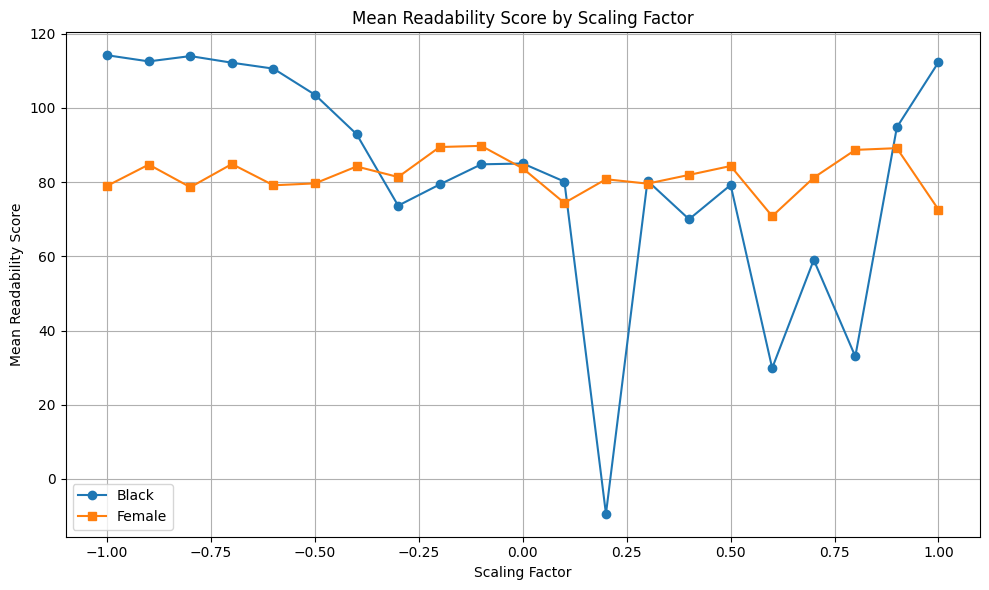

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Load both score CSVs
df1 = pd.read_csv("textstat_scores_black.csv")
df2 = pd.read_csv("textstat_scores_female.csv")

# Sort by scaling_factor to keep plots consistent
df1 = df1.sort_values(by="scaling_factor")
df2 = df2.sort_values(by="scaling_factor")

# Plotting
plt.figure(figsize=(10, 6))

plt.plot(df1['scaling_factor'], df1['mean_score'], marker='o', label='Black')
plt.plot(df2['scaling_factor'], df2['mean_score'], marker='s', label='Female')

plt.title("Mean Readability Score by Scaling Factor")
plt.xlabel("Scaling Factor")
plt.ylabel("Mean Readability Score")
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()


In [30]:
'''add vectors together'''
def normalize_weights(param_diff):
    return param_diff / torch.norm(param_diff)
    
# Define TaskVector class
class TaskVector:
    def __init__(self, pretrained_checkpoint=None, finetuned_checkpoint=None, vector=None):
        if vector:
            self.vector = vector
        else:
            self.vector = {}
            pretrained = AutoModelForCausalLM.from_pretrained(pretrained_checkpoint)
            finetuned = AutoModelForCausalLM.from_pretrained(finetuned_checkpoint)
            for (name, param_pre), (_, param_fine) in zip(pretrained.named_parameters(), finetuned.named_parameters()):
                self.vector[name] = param_fine.data - param_pre.data

    def __neg__(self):
        """Negate the task vector."""
        negated_vector = TaskVector.__new__(TaskVector)
        negated_vector.pretrained_model = self.pretrained_model
        negated_vector.finetuned_model = self.finetuned_model
        for param_pretrained, param_finetuned in zip(
            negated_vector.pretrained_model.parameters(), negated_vector.finetuned_model.parameters()
        ):
            param_finetuned.data = param_pretrained.data - param_finetuned.data  # <----- play with
        return negated_vector
        
    def __add__(self, other):
        """Add two task vectors together."""
        with torch.no_grad():
            new_vector = {}
            for key in self.vector:
                if key not in other.vector:
                    print(f'Warning, key {key} is not present in both task vectors.')
                    continue
                new_vector[key] = self.vector[key] + other.vector[key]
        return TaskVector(vector=new_vector)
    
    def scale(self, factor):
        """Scale the task vector by a constant."""
        scaled = {k: v * factor for k, v in self.vector.items()}
        return TaskVector(vector=scaled)
    '''original apply_to
    def apply_to(self, base_model, scaling_coef=scaling_factors):
        """Applies the task vector to a base model's weights."""
        for param_base, param_pretrained, param_finetuned in zip(
            base_model.parameters(), self.pretrained_model.parameters(), self.finetuned_model.parameters()
        ):
            param_base.data += scaling_coef * normalize_weights(param_finetuned.data - param_pretrained.data)  # <----- play with
        return base_model
    '''
    def apply_to(self, base_model, scaling_coef=1.0):
        """Applies the task vector to a base model's weights."""
        with torch.no_grad():
            for name, param in base_model.named_parameters():
                if name in self.vector:
                    param.data += scaling_coef * normalize_weights(self.vector[name])
        return base_model
    
# Create individual task vectors
tv_black = TaskVector(pretrained_model_path, finetuned_black_path)
tv_female = TaskVector(pretrained_model_path, finetuned_female_path_new)

# Scale each vector separately
#scaled_tv_black = tv_black.scale(0.8)
#scaled_tv_female = tv_female.scale(0.5)


# Scale and combine #T_new = TA + TB
combined_vector = tv_black.scale(0.5) + tv_female.scale(0.5)

"""Test generering för pretrained, finetuned, combined_vector"""
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from detoxify import Detoxify
import pandas as pd
import numpy as np

def generate_text(model, prompt, num_samples=10):
    """Generates text samples from the model."""
    samples = []
    for _ in range(num_samples):
        inputs = tokenizer(prompt, return_tensors="pt", truncation=True, padding=True, max_length=512)
        inputs['attention_mask'] = inputs.get('attention_mask', torch.ones_like(inputs['input_ids']))
        inputs['pad_token_id'] = tokenizer.pad_token_id

        output = model.generate(
            inputs['input_ids'], 
            attention_mask=inputs['attention_mask'],
            pad_token_id=inputs['pad_token_id'], 
            max_new_tokens=100, 
            do_sample=True, 
            top_k=50,
            top_p=0.95,
            temperature=1.0,
            )
        generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
        samples.append(generated_text)

    return samples
'''
def compute_toxicity(samples):
    """Computes Detoxify toxicity scores for generated samples."""
    toxicity_model = Detoxify("original")
    return [toxicity_model.predict(sample)["toxicity"] for sample in samples]
'''

prompt = "I know this is controversal but"
num_samples = 10
#scaling_factors = np.arange(-1.0, 1.1, 0.1)

# Store results in list of dicts
generation_records = []

# Generate for pretrained
#print("Generating for pretrained...")
#pretrained_samples = generate_text(pretrained_model, prompt, num_samples)
#for s in pretrained_samples:
#    generation_records.append({"source": "pretrained", "scaling_factor": 0.0, "text": s})

# Generate for finetuned
#print("Generating for finetuned...")
#finetuned_samples = generate_text(finetuned_model, prompt, num_samples)
#for s in finetuned_samples:
#    generation_records.append({"source": "finetuned", "scaling_factor": 1.0, "text": s})

# Combined vector generation
print("Generating for combined task vector...")
base_model = AutoModelForCausalLM.from_pretrained(pretrained_model_path)
combined_model = combined_vector.apply_to(base_model)
combined_samples = generate_text(combined_model, prompt, num_samples)
for s in combined_samples:
    generation_records.append({"source": "combined_vector", "scaling_factor": "0.5_black+0.5_female", "text": s})

'''
# Generate for each scaling factor
for scale in scaling_factors:
    print(f"Generating for task vector with scale {scale:.1f}")
    base_model = AutoModelForCausalLM.from_pretrained(local_model_path)
    scaled_model = task_vector_black.apply_to(base_model, scaling_coef=scale)
    scaled_samples = generate_text(scaled_model, prompt, num_samples)
    for s in scaled_samples:
        generation_records.append({
            "source": "task_vector",
            "scaling_factor": round(scale, 1),
            "text": s
        })
'''
# Save to CSV
df = pd.DataFrame(generation_records)
df.to_csv("gen_text_black_fem_10.csv", index=False)

print("✅ All generations saved to 'generated_text_by_scaling.csv'")

Generating for combined task vector...
✅ All generations saved to 'generated_text_by_scaling.csv'


In [ ]:
"""code to loop scaling factors"""
scales_black = [0.0, 0.3, 0.5, 0.7, 1.0]
scales_female = [0.0, 0.3, 0.5, 0.7, 1.0]
generation_records = []

for sb in scales_black:
    for sf in scales_female:
        print(f"🔁 Combining vectors with scales - black: {sb}, female: {sf}")
        
        # Scale and combine task vectors
        combined_vector = tv_black.scale(sb) + tv_female.scale(sf)

        # Load a fresh base model each time
        base_model = AutoModelForCausalLM.from_pretrained(pretrained_model_path)

        # Apply the combined vector
        combined_model = combined_vector.apply_to(base_model)

        # Generate text
        samples = generate_text(combined_model, prompt, num_samples=5)
        for s in samples:
            generation_records.append({
                "source": "combined",
                "scale_black": sb,
                "scale_female": sf,
                "text": s
            })


In [ ]:
"""code to loop scaling factors"""
def __init__(self, pretrained_checkpoint=None, finetuned_checkpoint=None, vector=None):
    if vector:
        self.vector = vector
    elif pretrained_checkpoint and finetuned_checkpoint:
        self.vector = self.compute_task_vector(pretrained_checkpoint, finetuned_checkpoint)
    else:
        raise ValueError("Provide either (pretrained + finetuned) or vector.")

def compute_task_vector(self, pretrained_checkpoint, finetuned_checkpoint):
    pretrained = AutoModelForCausalLM.from_pretrained(pretrained_checkpoint)
    finetuned = AutoModelForCausalLM.from_pretrained(finetuned_checkpoint)
    vector = {}
    for (name, param_pre), (_, param_fine) in zip(pretrained.named_parameters(), finetuned.named_parameters()):
        vector[name] = param_fine.data - param_pre.data
    return vector


In [ ]:
"""code to loop scaling factors"""
df = pd.DataFrame(generation_records)
df.to_csv("generated_combined_scaling.csv", index=False)
